# Dip target
Purpose: Find target best fitted for dips

Initial plan: Use NVI over close

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ta.volume import NegativeVolumeIndexIndicator
from ta.volatility import BollingerBands
df = pd.read_csv("../data/BTCUSDT-hour-target.csv")

In [236]:
# Temporary solution
import sys
sys.path.insert(0, '..')
import useful_functions as uf
import target as target

In [216]:
i = NegativeVolumeIndexIndicator(df.close, df.volume)
df["nvi"] = i.negative_volume_index()
df["nvi_o_close"] = list(map(lambda n, c: n/c, df.nvi, df.close))
df["nvi_o_close_rate_50"] = uf.get_rate(uf.get_moving_average(df.nvi_o_close, 50))

(array([1.1000e+01, 3.2000e+02, 4.7400e+03, 2.6372e+04, 1.0650e+03,
        1.7300e+02, 7.6000e+01, 6.2000e+01, 1.8000e+01, 3.0000e+00]),
 array([-0.33358416, -0.23073402, -0.12788388, -0.02503374,  0.0778164 ,
         0.18066654,  0.28351668,  0.38636682,  0.48921696,  0.5920671 ,
         0.69491724]),
 <BarContainer object of 10 artists>)

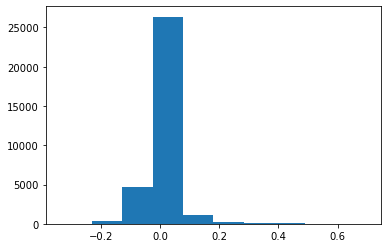

In [217]:
plt.hist(df["nvi_o_close_rate_50"])

In [218]:
df["target_base"] = target.get_wr_target(df.close, 200, 0.)

In [219]:
df.target_base.value_counts()

1    17619
0    15271
Name: target_base, dtype: int64

In [220]:
df["nvi_classified"] = uf.classify(df.nvi_o_close_rate_50, 0.)

In [221]:
df.nvi_classified.value_counts()

1    17242
0    15648
Name: nvi_classified, dtype: int64

In [222]:
df["target"] = target.zip_target(df.target_base, df.nvi_classified)

In [223]:
df.target.value_counts(), df.target.value_counts()[1]/df.target.value_counts()[0]

(0    23894
 1     8996
 Name: target, dtype: int64,
 0.3764961915125136)

In [224]:
i = BollingerBands(df.close, window=100, window_dev=2)
df["bb"] = i.bollinger_pband()

In [225]:
df["bb"] = uf.classify(list(map(lambda x: -x, df.bb)), -0.2)

In [226]:
df.bb.value_counts()

0    26716
1     6174
Name: bb, dtype: int64

In [227]:
df["target"] = target.zip_target(df.target, df.bb)

In [228]:
df.target.value_counts(), df.target.value_counts()[1]/df.target.value_counts()[0]

(0    29796
 1     3094
 Name: target, dtype: int64,
 0.10383944153577661)

In [229]:
d = df[-5000:]

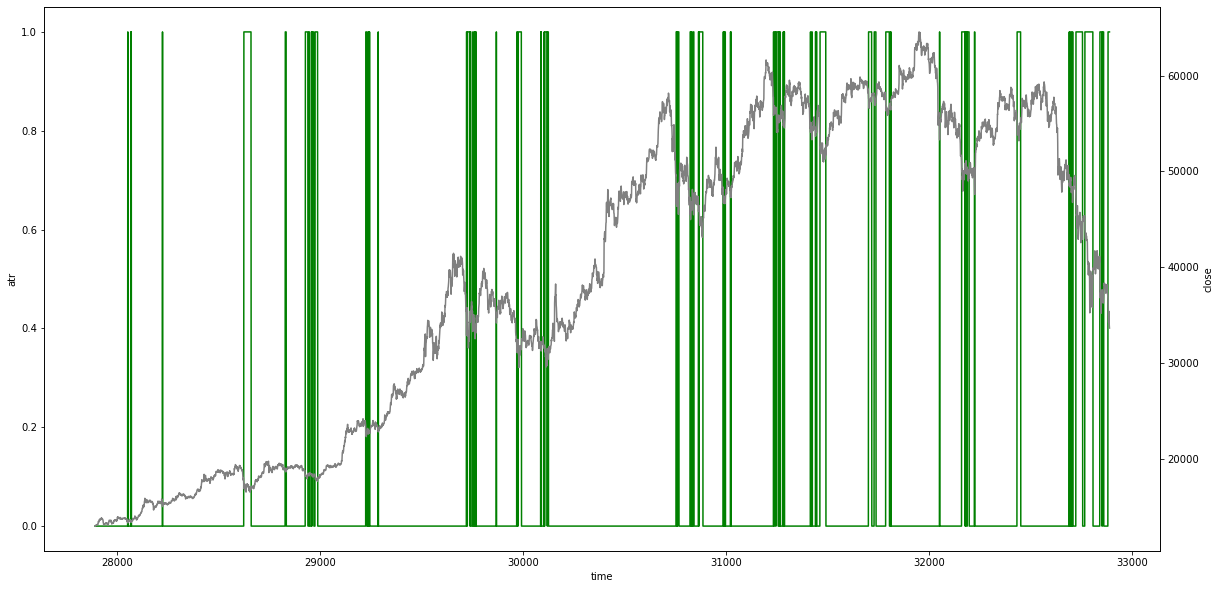

In [230]:
fig,ax = plt.subplots(figsize=(20, 10))
ax.plot(d.target,
        color="green")
ax.set_xlabel("time")
ax.set_ylabel("atr")

ax2=ax.twinx()
ax2.plot(d.close,
         color="gray")

ax2.set_ylabel("close")
# fig.legend(["a", "b", "c", "d"])
plt.show()

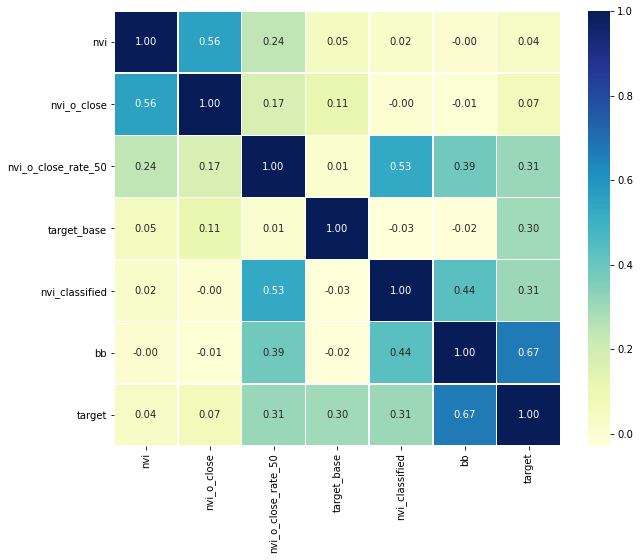

In [231]:
indicators = list(df.columns)[13:]
indicators.append("target")

d = df[list(indicators)].copy()
corr_matrix = d.corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

## Adding target and nvi_o_close_rate_50 as nvi

In [237]:
df = pd.read_csv("../data/BTCUSDT-hour-target.csv")
df.drop(['target'], inplace=True, errors='ignore')

In [238]:
i = NegativeVolumeIndexIndicator(df.close, df.volume)
nvi_o_close = pd.Series(list(map(lambda n, c: n/c, i.negative_volume_index(), df.close)))
nvi = uf.get_rate(uf.get_moving_average(nvi_o_close, 50))
df["nvi"] = uf.classify(nvi, 0.)

target_base = target.get_wr_target(df.close, 200, 0.)
target_nvi = target.zip_target(target_base, df.nvi)

i = BollingerBands(df.close, window=100, window_dev=2)
df["bb"] = i.bollinger_pband()
df["bb"] = uf.classify(list(map(lambda x: -x, df.bb)), -0.2)
df["target"] = target.zip_target(target_nvi, df.bb)

In [239]:
df.target.value_counts(), df.target.value_counts()[1]/df.target.value_counts()[0]

(0    29796
 1     3094
 Name: target, dtype: int64,
 0.10383944153577661)

In [240]:
df.to_csv("../data/BTCUSDT-hour-target-dip.csv", index=False) #Default